In [1]:
import numpy as np
import matplotlib.pyplot as plt

In this homework assignment, we'll learn about several things related to linear regression. First, we'll use simulated data to illustrate how to compute a p-value to assess whether there is a linear relationship between two variables. After this, we'll download some data from mouse experiments and use linear regression to relate neural activity from different brain areas to the speed at which the mouse is turning a wheel. We'll illustrate the danger of overfitting with high-dimensional models and how it can be overcome using regularization and cross-validation.

# Linear regression with simulated data: evidence of a linear relationship

When we do linear regression to relate two sets of data $x$ and $y$, we can think of this as testing whether there is a significant linear relationship between the two variables. Thus, we want to test the null hypothesis $H_0$: that there is *no* linear relationship between $x$ and $y$. As we learned in class, the proper way to do this is to ask, assuming $H_0$ is true, how unlikely we would be to get the data that we have. This probability is the $p$-value, and, if it is sufficiently small, we can reject the null hypothesis and conclude that there *is* a significant linear relationship between $x$ and $y$.

In practice, scientists almost always use built-in methods from statistical software (like NumPy and SciPy) to calculate these $p$-values. We will do this below. In order to understand where the result comes from, though, we'll also compute a $p$-value for a regression problem by hand using a simulated dataset in addition to applying the built-in method below.

First let's create some simulated data and plot it.

Text(0, 0.5, 'y')

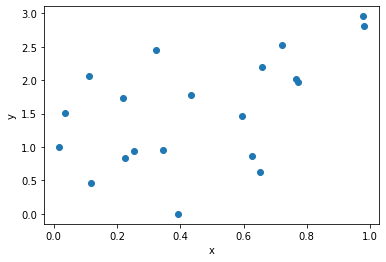

In [2]:
n = 20  # number of data points

# The true intercept and slope for the data if noise isn't present:
alpha_true = 0.5
beta_true = 1.5

# Simulated data:
x_data = np.random.rand(n)
noise_amp = 0.9
noise = noise_amp*np.random.randn(n)
y_data = alpha_true + beta_true*x_data + noise

plt.plot(x_data, y_data, 'o')
plt.xlabel('x')
plt.ylabel('y')

In an earlier homework assinment, we learned how to use `np.polyfit()` to compute a linear fit to data like this. Here we will use a more sophisticated function called `linregress()` for doing linear regression. This gives the same result as `np.polyfit()`, and, in addition, lets us compute a $p$-value.

In [3]:
from scipy import stats

fit = stats.linregress(x_data, y_data)

beta = fit.slope
alpha = fit.intercept
print('beta: ', beta)
print('alpha: ', alpha)
print('r-squared: ', fit.rvalue**2)
print('p-value: ', fit.pvalue)

beta:  1.4417559766478736
alpha:  0.8928129702379027
r-squared:  0.2768921911272771
p-value:  0.01715816675545002


Plot the resulting fit.

Text(0, 0.5, 'y')

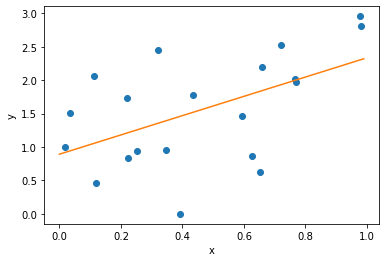

In [4]:
plt.plot(x_data, y_data, 'o')
x_pts = np.arange(0,1,0.01)
y_pred = alpha + beta*x_pts
plt.plot(x_pts, y_pred)
plt.xlabel('x')
plt.ylabel('y')

How can we compute this $p$-value ourselves? Our null hypothesis is that the data is described by a linear fit with zero slope and the same mean as the original data, i.e. $y = \alpha_0$ (the subscript just reminds us that this is part of the null hypothesis $H_0$). In the following three exercises, we will test how unlikely the slope that we got above would be if the null hypothesis were true.

**Exercise 1 (calculation)**

Under the null hypothesis, the fitting function for the data is $g(x) = \alpha_0$. Show that the value of $\alpha_0$ that minimizes the mean-squared error:
$$
E = \frac{1}{2} \sum_{i=1}^n (y_i - g(x_i))^2
$$
is just the average of the data, i.e. $\alpha_0 = \frac{1}{n} \sum_i y_i$.

**Exercise 2**

Use the same $x$ data points as before, and create $n$ new $y$ data points from the null-hypothesis model, i.e. like the original data we created, but with intercept $\alpha_0$ given by the expression above and slope equal to zero. Even though the data was generated from a model with zero slope, a linear fit probably won't give a value of $\beta$ exactly equal to zero. Perform a linear fit, print the values of $\beta$ and $\alpha$ found by the fit, and plot the fit line along with the null-hypothesis data.

In [5]:
### Your code here ###

**Exercise 3**

Make a for loop to generate data (each time with different noise) and perform a fit 10000 times. Print the fraction of iterations in which the slope found by the fit to the null-hypothesis data has a slope with magnitude (i.e. regardless of the sign of the slope) greater than or equal to the slope found for the first regression we did on the original data. This fraction is our $p$-value, and it should agree to within a factor of two or so with the value found in the first fit we did above.

In [6]:
### Your code here ###

# Load data from Steinmetz experiments

For the rest of this assignment, we'll use some data from mouse experiments performed by Nick Steinmetz and colleagues and described in the paper here: https://www.nature.com/articles/s41586-019-1787-x.

This data was used as part of the Neuromatch Academy 2020 online summer school and has a nice video explaining it here: https://www.youtube.com/watch?v=WXn4-FpVaOo.

To summarize briefly, spiking activity from neurons in many brain regions was recorded in mice performing a decision-making task. In the task, visual gratings appeared on the left and right side before a head-fixed mouse, and the mouse had a turn a steering wheel toward the grating with higher contrast in order to obtain a reward.

In [7]:
# Retrieve the data from online and save it to local .npz files.

import os, requests

fname = []
for j in range(3):
    fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
    if not os.path.isfile(fname[j]):
        try:
            r = requests.get(url[j])
        except requests.ConnectionError:
            print("!!! Failed to download data !!!")
        else:
            if r.status_code != requests.codes.ok:
                print("!!! Failed to download data !!!")
            else:
                with open(fname[j], "wb") as fid:
                    fid.write(r.content)


In [8]:
# Load all of the data into one big array

alldat = np.array([])
for j in range(len(fname)):
    alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# Select just one session of the recordings here:
dat = alldat[0]

# Each element of alldat is a Python dictionary with keys describing the different types of data:
print(dat.keys())


dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned). 

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron. 
* `dat['ccf_axes']`: axes names for the Allen CCF. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera. 
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time. 
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  




# Neural encoding of wheel turning

In the following exercises, we'll use multivariate regression to relate neuron firing to the mouse's behavior.

In [9]:
# The following 2D array has the wheel turning speed from each trial at each timestep:
wheel_speed = dat['wheel'][0,:,:]

# For later convenience, extract the numbers of trials and timesteps:
(n_trials, n_timesteps) = np.shape(wheel_speed)
print('(n_trials, n_timesteps): ', (n_trials, n_timesteps))

(n_trials, n_timesteps):  (214, 250)


**Exercise 4**

Make a plot of the wheel speed as a function of time for the first ten trials. Make sure that the x axis is correctly labelled, with time in seconds.



In [10]:
### Your code here ###

In the above plot, you should notice that there isn't much turning before the cue turns on at 500ms. In many trials, there's also not much turning toward the end of the trial, after the mouse has registered its response. Let's calculate the mean response time across trials and the timebin in which it occurs.

In [11]:
print('mean response time in seconds: ', np.mean(dat['response_time']))

dt = dat['bin_size']  # duration of each time bin (i.e. 10ms--see the data description above)
response_timebin = int(np.mean(dat['response_time'])/dt)

print('time bin: ', response_timebin)

mean response time in seconds:  1.5890609282309043
time bin:  158


Now let's average the wheel turning speed from each trial over the time window between the cue and the average time the response was registered and plot a histogram of the average turning speeds from different trials.

Text(0, 0.5, 'Count')

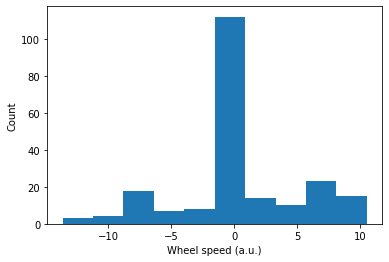

In [12]:
cue_timebin = 50
wheel_speed_avg = np.mean(wheel_speed[:,cue_timebin:response_timebin], axis=1) 

# Plot the data:
plt.hist(wheel_speed_avg, bins=10)
plt.xlabel('Wheel speed (a.u.)')
plt.ylabel('Count')

Because it looks like there are a lot of trials in which the mouse doesn't move the wheel at all, let's use the mask defined below to create a new array, `wheel_speed_moving`, which only keeps the trials in which the absolute value of the wheel speed is >0.1. We can also make a histogram of this data and print the number of trials that it contains.

Number of trials with wheel movement:  139


Text(0, 0.5, 'Count')

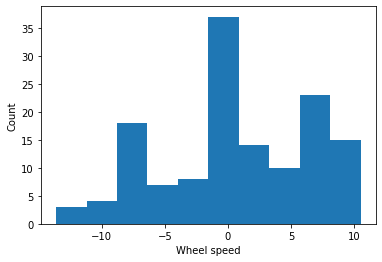

In [13]:
mask_moving = abs(wheel_speed_avg) > 0.1

wheel_speed_moving = wheel_speed_avg[mask_moving]
print('Number of trials with wheel movement: ', len(wheel_speed_moving))

# Plot the data:
plt.hist(wheel_speed_moving)
plt.xlabel('Wheel speed')
plt.ylabel('Count')

In what follows we'll use `wheel_speed_moving` for multivariate regression, relating this data to the firing rates of neurons in different brain areas. Let's next look at a list of the brain areas from which the neurons were recorded.

In [14]:
# Each entry in the array below is the brain area from which a neuron was recorded.

dat['brain_area'][:20]  # brain areas for the first 20 neurons

array(['ACA', 'MOs', 'ACA', 'LS', 'MOs', 'ACA', 'root', 'MOs', 'MOs',
       'LS', 'LS', 'LS', 'MOs', 'LS', 'LS', 'LS', 'ACA', 'MOs', 'ACA',
       'MOs'], dtype='<U4')

Now we'll make a list of all of the brain areas in which 30 or more neurons were recorded. We can make a list out of this and use the `.count()` method to count the number of occurrences of an item in a list.

In [15]:
n_min = 30  # keep brain areas with at least this many neurons
area_list = []
for area in set(dat['brain_area']):
    if list(dat['brain_area']).count(area) > n_min:
        area_list.append(area)   
print(area_list)

['LS', 'DG', 'SUB', 'MOs', 'CA3', 'ACA', 'VISp']


Translation of some of these:
- CA3: Part of hippocampus
- DG: Dentate gyrus (another part of hippocampus)
- VISp: Posterior visual cortex
- MOs: Secondary motor area

Brain areas may differ depending on which recording session was chosen above.

As explained above, the spiking data is in `dat['spikes']`, which is a 3D array. It is organized so that `dat[spikes][i,j,k]` is the number of spikes emitted by neuron `i` in trial `j` at timestep `k`. Next we will get the spiking data from the first 30 neurons in one particular brain area and average the data over the same time window that we did in Exercise 5 above.

In [16]:
# Get all of the spiking data from just one brain area:
area = 'MOs'
mask_area = dat['brain_area']==area
spikes = dat['spks'][mask_area,:,:]

# Use the same mask as above to keep only trials in which the wheel was moving:
spikes = spikes[:,mask_moving]

# Keep just the first 30 neurons:
spikes = spikes[:n_min,:,:]

n_neurons, n_trials, n_timesteps = np.shape(spikes)

# Make a new array of spiking data, where the data is averaged over time as we did for the wheel speed data:
spikes_avg = np.mean(spikes[:,:,cue_timebin:response_timebin], axis=2)

We can plot a histogram of the trial-averaged neural activity, where each count in the histogram is one neuron.

Text(0, 0.5, 'Count')

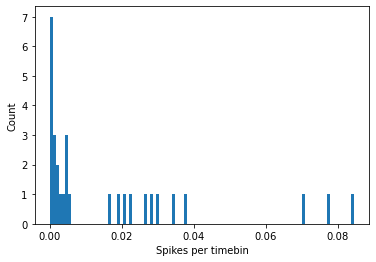

In [17]:
plt.hist(np.mean(spikes_avg, axis=1), bins=100)  # use narrow bins since lots of firing rates are close to zero
plt.xlabel('Spikes per timebin')
plt.ylabel('Count')

**Exercise 5**

Copy the above block of code below and modify it to create a function `spks(area)`, where the input to the function is one of the strings denoting a brain area from `area_list` that we defined above, and the function returns `spikes_avg`, a 2D array with the time averaged activity (averaged over the same time window as we used above) for each neuron in that brain area and in each trial.

In [18]:
### Your code here ###

Next we'll fit a multivariate regression model to predict the wheel speed from the neural activity in this area. The $r^2$ value tells us how good our fit is, where $r^2=1$ would be a perfect fit. Here we'll use the function `LinearRegression()` to do the fit since it allows us to do regression with more than one variable. We'll use the function we just created to get the time-averaged spiking data from this area.

In [19]:
from sklearn import linear_model

# Uncomment the following line after you have completed Exercise 5:
#spikes_avg = spks('MOs')  # use the function we just defined to get the time-averaged spiking activity

regr = linear_model.LinearRegression()  # regr is an object that does linear regression

# Formally, regr is an instance of a class, which is a collection of functions and variables.
# fit() and score() are two functions that belong to regr. The .T below switches rows and columns, 
# since the function wants the input to be an n_trials by n_neurons array:
regr.fit(spikes_avg.T, wheel_speed_moving)  # fit the data
r_squared = regr.score(spikes_avg.T, wheel_speed_moving)  # get the r-squared value

print(area + ' r-squared: ', r_squared)

MOs r-squared:  0.6308410864227549


**Exercise 6**

Copy and adapt the code from the previous cell, creating a for loop to compute $r^2$ for predicting the wheel speed from neural activity just as above, but now for multiple brain areas. Each iteration of the for loop should compute $r^2$ using the first 30 neurons in one of the brain areas for which there are 30 or more neurons recorded. Recall that we previously identified these brain areas and put them into the list `area_list`. Print the brain areas together with the $r^2$ value for each brain area.

In [20]:
### Your code here ###

These values look pretty good, but looks can be deceiving, as we show in the next exercise.

**Exercise 7**

Repeat the above exercise, but with the data split into training and testing sets. Use the first 80% of trials as training data and the last 20% as testing data. (To make this easier, this is done for the wheel speed data in the first block of code below. You'll have to do the same thing with the spiking data in your solution.) Use the training sets of wheel speed and spiking data to train the regression model with `regr.fit()` and the testing sets to compute $r^2$ using `regr.score()`. (If you don't feel confident that you got the previous exercise right, try doing this just for the one brain area that we analyzed right before Exercise 8.)

In [21]:
# Split the wheel speed data into training and testing sets:
n_trials = len(wheel_speed_moving)
wheel_speed_train = wheel_speed_moving[:int(0.6*n_trials)]
wheel_speed_test = wheel_speed_moving[int(0.6*n_trials):]

In [22]:
### Your code here ###

Because the performance on the testing data is in many cases much worse than the performance on the training data, it looks like the model is overfitting. As we discussed in class, two ways to prevent overfitting are **regularization**, which tries to keep parameters small, and **cross-validation**, which uses the performance on testing data to determine fitting parameters like the strength of the regularization. In the next exercise, we use a fitting method that incorporates both of these.

**Exercise 8**

Repeat the previous exercise, but now use `RidgeCV()` rather than `LinearRegression()` to perform the fit. You should find that the performance is much better for the testing data that was not used to train the model. (Again, if you aren't confident that you got Exercise 8 right, you can do this for just the one brain area that we analyzed right before Exercise 8.)

In [23]:
### Your code here ###